# Exploratory Data Analysis

Using the features selected after implementing CatBoost and utilizing it's feature importance score, data cleaning and null handling have been done below. 

The following were done for data cleaning.

- For features such as patient_age, an age_group was created to reduce the complexity of the dataset.
- With breast_cancer_diagnosis_code and desc, incorrect entries were corrected based on gender and ICD-9 codes and descriptions were changed to their ICD-10 equivalents.
- Incorrect zip-code entries were corrected or removed.

With the cleaned features, null handling was performed with some feature engineering.

- More than 60% of bmi values were missing. Since bmi is dependent on several factors such as age, location and socio-economic parameters, catboost was used to fill in missing values after training the same on exisiting dataset values. Validation RMSE was ~5.39. To reduce data complexity, bmi groups were created. Post this, both patient_age and bmi were dropped in favour of bmi_category and age_group.
- Average_of_Jun-17 had one missing value which was imputed using the temperature available in the zip3 closest to it's own zip3.
- 'income_household_35_to_50' and 'family_size' were missing for 5 patients all of whom belong to the same zip3. Since this information was entered based on the zip3, and that these patients were the only representatives of this zip3, these rows were dropped. These patients accounted for less than 0.04% of the dataset.

6 rows were dropped as part of this analysis, accounting for <0.05% decrease in the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helper import assign_age_groups, assign_icd_codes, replace_words, update_codes_and_desc, update_icd9_to_icd10, imputeBMI, categorize_bmi, metastatic_cancer_diagnosis_desc

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("train.csv")
df.head(5)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9

In [3]:
print(f"Total number of features: {len(df.axes[1])}")

Total number of features: 152


Based on the feature selection performed, the top 15 features are: 'patient_age', 'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code', 'bmi', 'Average of Jun-17', 'education_graduate', 'age_10_to_19', 'patient_zip3', 'commute_time', 'race_native', 'Average of Aug-16', 'income_household_35_to_50', 'divorced', 'Average of Jul-14', 'family_size'

To begin, exploration of null values shall be done.

In [4]:
sample = df.copy()
features = ['patient_id','patient_age', 'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_desc', 'bmi', 'Average of Jun-17', 
            'education_graduate', 'age_10_to_19', 'patient_zip3', 'commute_time', 'race_native', 'Average of Aug-16', 
            'income_household_35_to_50', 'divorced', 'Average of Jul-14', 'family_size', 'metastatic_diagnosis_period', 'age_group']


## Data Cleaning

Each feature, chosen through feature selection, shall be explored to determine if there are any issues with the data and fix the same.

### patient_age

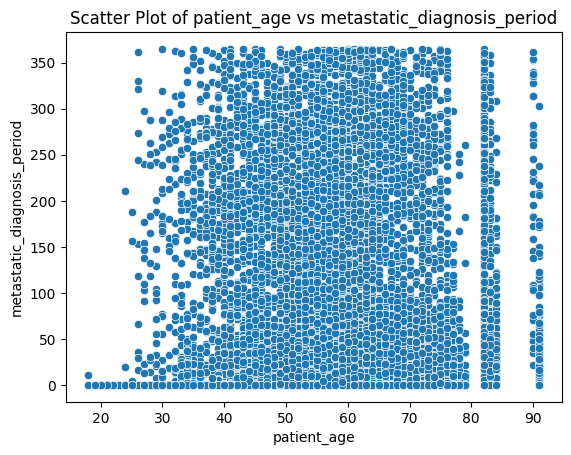

In [5]:
sns.scatterplot(x='patient_age', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('patient_age')
plt.ylabel('metastatic_diagnosis_period')
plt.title('Scatter Plot of patient_age vs metastatic_diagnosis_period')
plt.show()

Below, age is grouped to reduce the complexity of the dataset.

In [6]:
sample = assign_age_groups(sample)

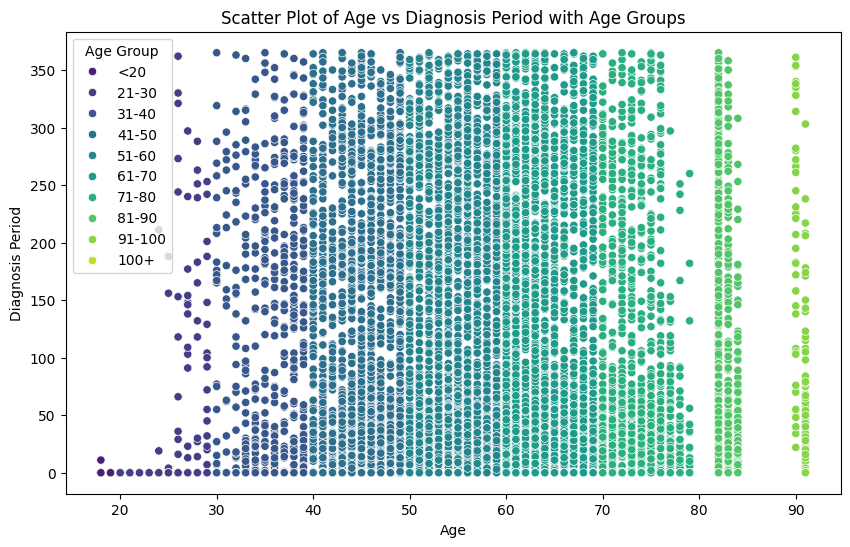

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='patient_age', y='metastatic_diagnosis_period', hue='age_group', data=sample, palette='viridis')
plt.xlabel('Age')
plt.ylabel('Diagnosis Period')
plt.title('Scatter Plot of Age vs Diagnosis Period with Age Groups')
plt.legend(title='Age Group')
plt.show()

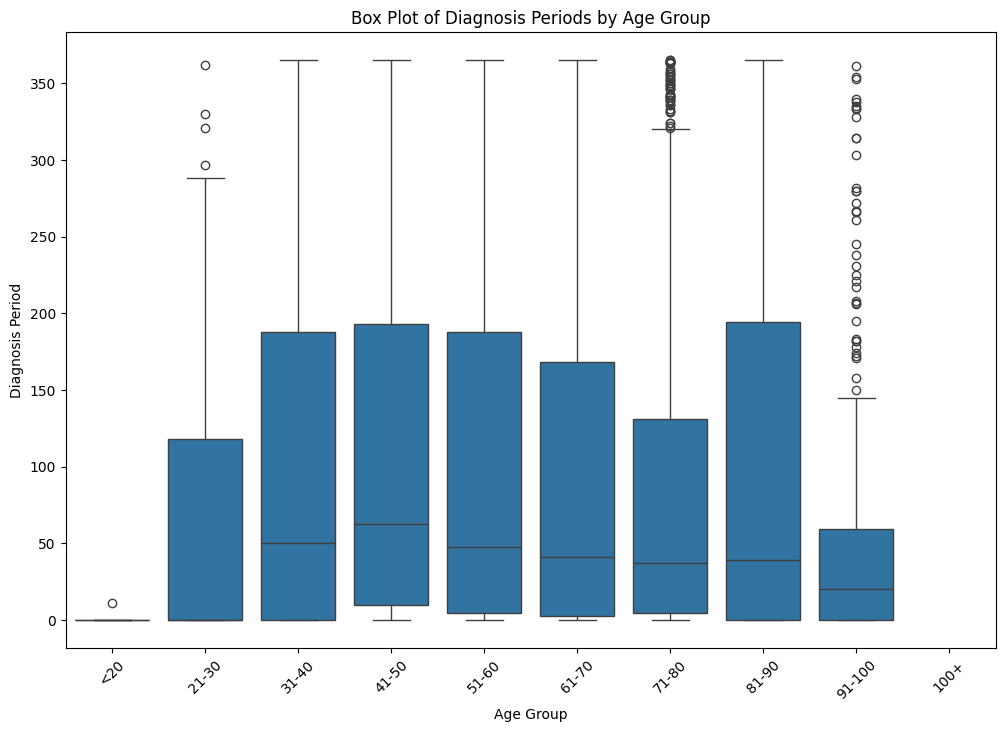

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('Age Group')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by Age Group')
plt.xticks(rotation=45)
plt.show()

### breast_cancer_diagnosis_desc + code

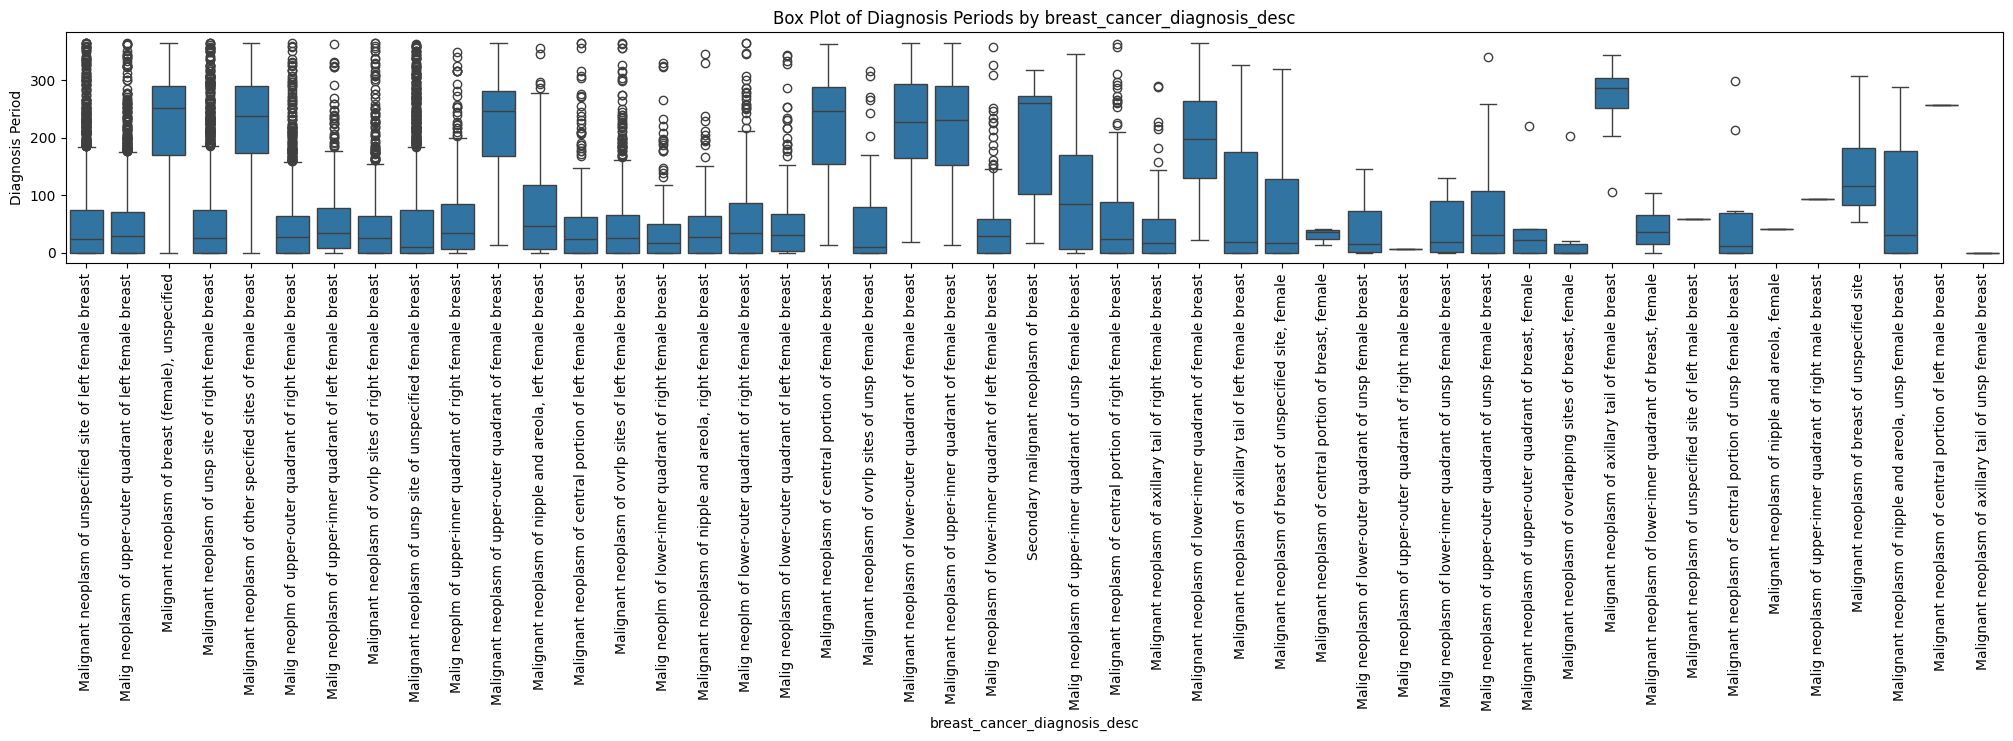

In [9]:
plt.figure(figsize=(25,3))
sns.boxplot(x='breast_cancer_diagnosis_desc', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('breast_cancer_diagnosis_desc')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by breast_cancer_diagnosis_desc')
plt.xticks(rotation=90)
plt.show()

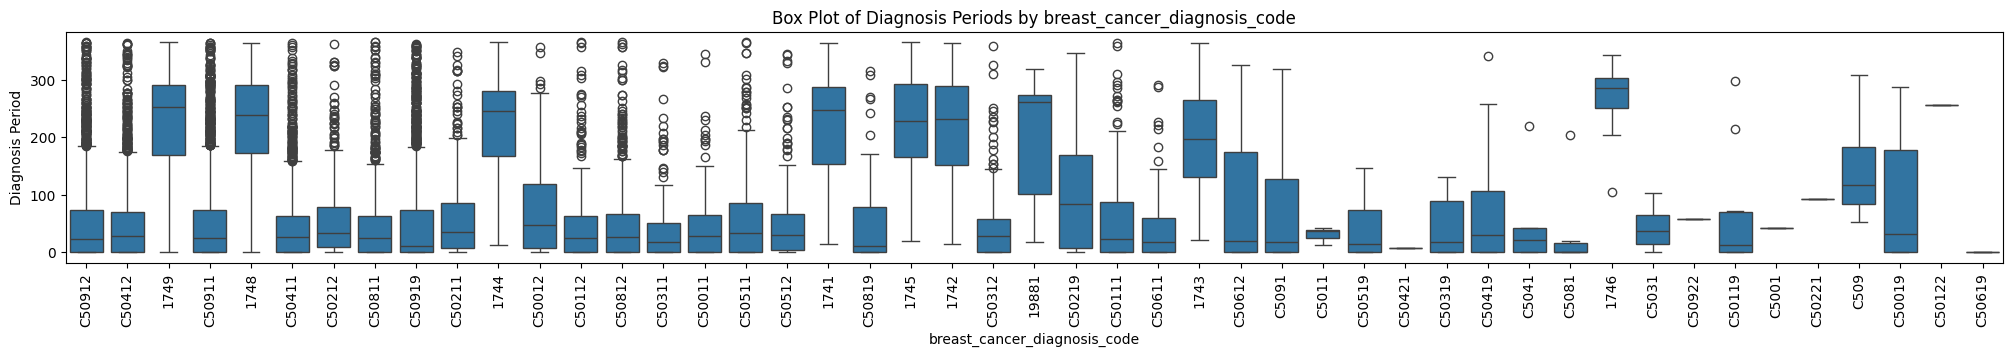

In [10]:
plt.figure(figsize=(25,3))
sns.boxplot(x='breast_cancer_diagnosis_code', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('breast_cancer_diagnosis_code')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by breast_cancer_diagnosis_code')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Check if every code has a unique description

def uniquenessCheck(df,col1,col2):
    result_dict = {}
    for key, value in zip(df[col1], df[col2]):
        if key not in result_dict:
            result_dict[key] = []
        if value not in result_dict[key]:
            result_dict[key].append(value)

    for key, values in result_dict.items():
        if len(values) > 1:
            print(f"{key}: {values}")
    print("Check done.")

uniquenessCheck(sample,"breast_cancer_diagnosis_code","breast_cancer_diagnosis_desc")

Check done.


Each code has it's own description. Let's explore them in parallel. A search online mentions that codes that begin with C or D are ICD-10 codes for neoplasms. Additionally, to verify that the codes have been entered correctly, ICD-9 codes have a length of 3-5 digits while ICD-10 have a length of 3-7 digits.

In [12]:
#Assignment of ICD-9 and ICD-10 codes
sample = assign_icd_codes(sample, 'breast_cancer_diagnosis_code')

In [13]:
#Check to ensure data contains accurate code lengths
def check_and_print(df):
    for index, row in df.iterrows():
        code = row['breast_cancer_diagnosis_code']
        icd_code = row['ICD_code']
        if icd_code == 'ICD_10':
            if len(code) < 3 or len(code) > 7:
                print(code)
        elif icd_code == 'ICD_9':
            if len(code) < 3 or len(code) > 5:
                print(code)

check_and_print(sample)

All codes seem to be accurately typed in terms of length. However, some descriptions have "male" written. Given that the original dataframe has "F" for all values in the column patient_gender, it may be that the male version of a similar code could have been accidentally entered. The below works on checking if this is a data entry issue.

In [14]:
# Let's first standardize all descriptions
# Change all Malig->Malignant, neoplm ->neoplasm, unsp->unspecified (for codes), ovrlp->overlapping 

sample = replace_words(sample, "breast_cancer_diagnosis_desc")

In [15]:
# Let's check if patient_gender is an accident by looking at the number of rows that contain "male" in breast_cancer_diagnosis_desc

df[df['breast_cancer_diagnosis_desc'].str.contains(r'\bmale\b', case=False, na=False)]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
712,133511,NaN,COMMERCIAL,PA,173,Northeast,Middle Atlantic,45,F,NaN,C50421,Malig neoplasm of upper-outer quadrant of right male breast,C773,NaN,NaN,7218.35,279.90,43.69,10.55,12.56,11.21,11.34,13.05,15.23,14.32,7.63,4.10,51.38,48.62,54.89,13.45,26.35,5.31,3.00,58.32,77876.83,1.29,1.11,2.37,3.11,2.85,6.91,12.12,18.37,17.11,21.79,12.96,34.75,37291.81,79.85,2817.81,207139.9,1004.98,26.91,9.44,42.56,25.05,15.40,7.57,22.96,42.78,67.35,3.77,8.81,1.50,93.24,1.51,0.48,0.11,0.01,1.74,2.91,5.15,12.77,6.02,0.83,29.18,5.26,7.50,33.19,31.42,38.06,52.65,61.24,71.46,76.93,71.24,64.76,56.30,41.41,35.09,23.69,27.98,34.61,50.72,62.21,71.05,73.86,70.25,66.38,56.58,40.64,37.48,27.30,21.77,36.07,52.68,67.03,71.17,74.10,72.79,69.15,53.38,48.80,45.36,29.01,33.39,46.73,50.90,59.62,71.17,77.23,76.81,70.20,57.18,45.98,35.06,34.83,40.63,38.94,57.06,59.95,71.57,76.05,70.98,66.89,59.56,42.89,32.68,27.80,37.49,36.78,47.55,66.70,70.40,75.45,75.67,69.69,56.51,40.45,36.92,7
1908,141903,Other,MEDICAID,FL,330,South,South Atlantic,66,F,24.0,C50922,Malignant neoplasm of unspecified site of left male breast,C7981,NaN,NaN,34958.92,1716.93,43.38,10.63,11.39,11.20,12.53,13.45,14.94,12.92,8.02,4.93,49.48,50.52,46.28,15.78,31.88,6.06,3.28,52.59,66478.65,3.36,2.97,3.89,3.80,4.21,9.09,12.71,17.46,13.49,14.56,14.46,29.02,32875.39,62.05,12264.35,350955.9,1563.18,39.90,13.20,29.02,27.58,19.00,11.21,30.21,44.04,63.13,

Since only 4 rows in the dataset contain "male" breast_cancer_diagnosis_desc, it is safe to assume that the code and description are mistakes. These will be corrected by referencing "ICD-CM-Codes.csv" developed for this project. Additionally, any ICD-9 codes whose conversion is available in the csv shall be converted to ICD-10 to reduce the number of unique values in the data.

In [16]:
#Replace all male codes+desc to female
sample = update_codes_and_desc(sample,"breast_cancer_diagnosis_code", "breast_cancer_diagnosis_desc")

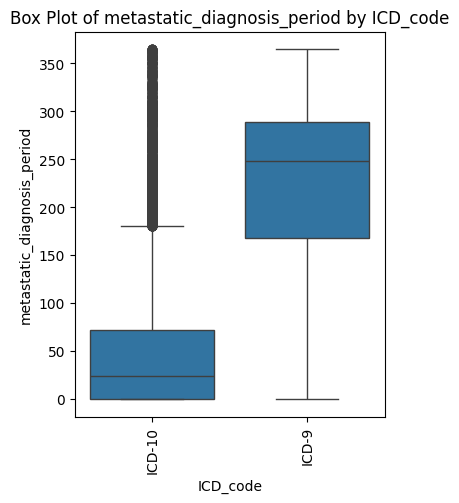

In [17]:
plt.figure(figsize=(4,5))
sns.boxplot(x='ICD_code', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('ICD_code')
plt.ylabel('metastatic_diagnosis_period')
plt.title('Box Plot of metastatic_diagnosis_period by ICD_code')
plt.xticks(rotation=90)
plt.show()

In [18]:
#Create categories for metastatic_codes

sample = metastatic_cancer_diagnosis_desc(sample)

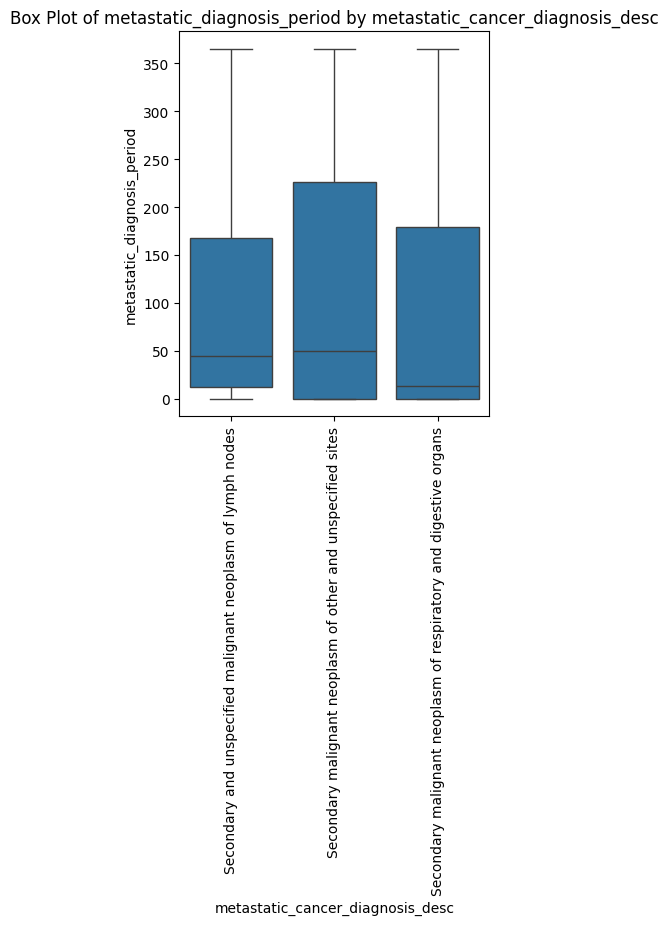

In [19]:
plt.figure(figsize=(4,5))
sns.boxplot(x='metastatic_cancer_diagnosis_desc', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('metastatic_cancer_diagnosis_desc')
plt.ylabel('metastatic_diagnosis_period')
plt.title('Box Plot of metastatic_diagnosis_period by metastatic_cancer_diagnosis_desc')
plt.xticks(rotation=90)
plt.show()

In [20]:
#Change all ICD-9 to ICD-10
icd_codes = pd.read_csv("ICD-CM-Codes.csv")
sample = update_icd9_to_icd10(sample,icd_codes, "ICD_code","breast_cancer_diagnosis_code","breast_cancer_diagnosis_desc")

In [21]:
print(f"Number of unique codes in the original dataset is {len(df['breast_cancer_diagnosis_code'].unique())}")
print(f"Number of unique codes in the modified dataset is {len(sample['breast_cancer_diagnosis_code'].unique())}")

Number of unique codes in the original dataset is 47
Number of unique codes in the modified dataset is 35


The number of codes (and descriptions) have been reduced from 47 to 35.

### patient_zip3

Based on [link](https://www.plansponsor.com/trivial-pursuits-can-zip-code-exist-one-state/#:~:text=ZIP%20Codes%20are%20not%20drawn,and%20Modoc%20County%2C%20California%3B%20and), it is not necessary that each state in the US has it's own zip3. However, a check shall be performed to determine if a single zip3 belongs to multiple states and a manual analysis will be conducted on these zip3s to ensure they are correctly entered.

In [22]:
def print_duplicate_zips(df):
    # Group by 'zip' and count the number of unique 'state' values for each 'zip'
    zip_counts = df.groupby('patient_zip3')['patient_state'].nunique()

    # Find zips that are associated with more than one state
    duplicate_zips = zip_counts[zip_counts > 1].index

    # Filter the original dataframe to include only rows with the duplicate zips
    duplicate_entries = df[df['patient_zip3'].isin(duplicate_zips)]

    # Iterate over the duplicate entries and print the results
    for zip_code in duplicate_zips:
        states = duplicate_entries[duplicate_entries['patient_zip3'] == zip_code]['patient_state'].unique()
        print(f"Zip3: {zip_code}, States: {', '.join(states)}")

print_duplicate_zips(df)

Zip3: 630, States: MO, IL
Zip3: 864, States: AZ, CA


From [link](https://about.usps.com/what/performance/service-performance/zip-3-by-area-district.htm), IL does not have a 630 zip3. Similarly, CA does not have an 864 zip3. Let's modify this below. 

Note: US states are also identified by a Region and Division as visible in the dataset. This however, cannot be used to identify a zip3.

#### zip3: 864

In [23]:
sample[sample["patient_zip3"]==864]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,age_group,metastatic_cancer_diagnosis_desc
5299,765445,White,MEDICARE ADVANTAGE,AZ,864,West,Mountain,66,F,40.00,C50919,Malignant neoplasm of unspecified site of unspecified female breast,C7981,NaN,NaN,8967.22,62.87,54.57,7.33,7.84,7.04,8.36,8.2,16.84,21.4,16.21,6.77,52.43,47.57,54.55,15.37,19.7,10.36,2.6,26.71,47036.15,4.32,3.28,5.68,5.03,6.79,12.44,14.25,22.84,11.03,8.3,6.02,14.32,26658.4,77.05,4008.3,178525.3,829.07,29.98,14.79,36.59,31.87,11.91,4.84,16.75,42.77,36.69,8.29,7.9,0.04,80.45,0.67,3.53,6.25,0.15,3.49,5.43,14.6,25.21,18.3,1.01,26.61,8.83,14.91,50.31,54.27,66.28,72.19,80.72,91.64,95.68,91.34,84.06,69.5,61.5,51.43,56.43,60.5,66.47,71.64,80.29,90.22,95.53,90.13,87.83,77.18,62.95,54.85,56.06,62.66,68.34,70.72,76.11,92.34,92.28,95.19,89.28,77.54,59.25,49.25,51.35,61.22,66.66,71.12,77.78,94.29,95.63,92.9,84.15,77.02,64.16,53.25,52.14,59.54,67.25,72.11,79.38,92.37,97.13,94.48,85.49,75.74,65.77,56.24,56.96,56.68,62.94,75.41,80.78,90.66,96.43,95.77,89.19,73.32,61.57,54.43,265,61-70,Secondary malignant neoplasm of other and unspecified sites
9229,861546,White,MEDICAID,CA,864,West,Mountain,70,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,8967.22,62.87,54.57,7.33,7.84,7.04,8.36,8.2,16.84,21.4,16.21,6.77,52.43,47.57,54.55,15.37,19.7,10.36,2.6,26.71,47036.15,4.32,3.28,5.68,5.03,6.79,12.44,14.25,22.84,11.03,8.3,6.02,14.32,26658.4,7

There is only one entry with the state of CA that has a zip3 of 864. However, all other geographic details are identical to patients in AZ. Let's check if CA has patients with a Region "West" and Division "Mountain".

In [24]:
sample[(sample["patient_state"] == "CA") & (sample["Region"] == "West") & (sample["Division"] == "Mountain")]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,age_group,metastatic_cancer_diagnosis_desc
9229,861546,White,MEDICAID,CA,864,West,Mountain,70,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,8967.22,62.87,54.57,7.33,7.84,7.04,8.36,8.2,16.84,21.4,16.21,6.77,52.43,47.57,54.55,15.37,19.7,10.36,2.6,26.71,47036.15,4.32,3.28,5.68,5.03,6.79,12.44,14.25,22.84,11.03,8.3,6.02,14.32,26658.4,77.05,4008.3,178525.3,829.07,29.98,14.79,36.59,31.87,11.91,4.84,16.75,42.77,36.69,8.29,7.9,0.04,80.45,0.67,3.53,6.25,0.15,3.49,5.43,14.6,25.21,18.3,1.01,26.61,8.83,14.91,50.31,54.27,66.28,72.19,80.72,91.64,95.68,91.34,84.06,69.5,61.5,51.43,56.43,60.5,66.47,71.64,80.29,90.22,95.53,90.13,87.83,77.18,62.95,54.85,56.06,62.66,68.34,70.72,76.11,92.34,92.28,95.19,89.28,77.54,59.25,49.25,51.35,61.22,66.66,71.12,77.78,94.29,95.63,92.9,84.15,77.02,64.16,53.25,52.14,59.54,67.25,72.11,79.38,92.37,97.13,94.48,85.49,75.74,65.77,56.24,56.96,56.68,62.94,75.41,80.78,90.66,96.43,95.77,89.19,73.32,61.57,54.43,104,71-80,Secondary and unspecified malignant neoplasm of lymph nodes


This is the same patient that shows up with patients from AZ. Additionally, a search online mentions that AZ is identified as a Mountain state but not CA. Thus, it is safe to change this patient's state to AZ.

In [25]:
sample.loc[(sample["patient_state"] == "CA") & (sample["Region"] == "West") & (sample["Division"] == "Mountain"), "patient_state"] = "AZ"

#### zip3: 630

In [26]:
sample[sample["patient_zip3"]==630]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,age_group,metastatic_cancer_diagnosis_desc
475,327408,NaN,COMMERCIAL,MO,630,Midwest,West North Central,65,F,NaN,C50412,Malignant neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,12912.19,292.37,42.9,11.66,12.6,10.55,11.68,12.48,14.69,14.8,7.82,3.69,50.12,49.88,54.56,12.97,26.06,6.41,3.03,52.99,76472.07,1.95,1.27,2.53,2.93,4.68,8.28,12.62,18.76,14.46,17.11,15.39,32.5,37721.78,81.09,5011.0,210077.2,956.47,26.87,8.79,31.28,33.15,16.06,10.74,26.8,38.46,62.87,4.67,10.43,2.08,87.0,5.99,1.74,0.11,0.02,0.7,4.43,2.3,14.21,9.4,0.48,30.92,7.78,9.06,34.02,34.3,37.37,52.76,64.77,73.31,74.41,74.6,71.25,56.8,42.11,31.9,25.23,25.54,38.49,55.88,65.63,74.5,72.78,76.83,66.93,57.57,37.64,38.1,31.02,25.6,43.2,57.69,65.94,73.72,76.73,73.48,71.26,57.52,48.64,43.12,30.71,37.26,49.89,56.7,62.85,76.98,78.06,76.99,71.82,62.39,49.78,32.33,34.86,44.12,47.36,58.59,63.95,73.13,79.25,72.44,70.34,59.86,46.5,34.35,27.53,36.05,41.84,48.02,72.22,76.8,77.66,76.2,72.34,57.22,37.13,36.76,0,61-70,Secondary and unspecified malignant neoplasm of lymph nodes
596,417760,NaN,COMMERCIAL,MO,630,Midwest,West North Central,57,F,26.88,C50511,Malignant neoplasm of lower-outer quadrant of right female breast,C773,NaN,NaN,12912.19,292.37,42.9,11.66,12.6,10.55,11.68,12.48,14.69,14.8,7.82,3.69,50.12,49.88,54.56,12.97,26.06,6.41,3.03,52.99,76472.07,1.95,1.27,2.53,2.93,4.68,8.28,12.62,18.76,14.46,17.11,15.3

Here, only a single patient with a zip3 630 belongs to the state IL. All other state information such as Region and Division are correct. IL has 29 zip3 both in the dataset and as mentioned online. Additionally, since several features such as the weather and socio-economic data have been entered using the zip3, it is safer to drop this patient from the dataset.

In [27]:
#Removing patients from IL that have the zipcode 630
sample = sample[~((sample["patient_zip3"] == 630) & (sample["patient_state"] == "IL"))]

## Null Handling

In [28]:
sample = sample[features]
sample.isna().sum()

patient_id                             0
patient_age                            0
breast_cancer_diagnosis_desc           0
breast_cancer_diagnosis_code           0
metastatic_cancer_diagnosis_desc       0
bmi                                 9071
Average of Jun-17                      1
education_graduate                     0
age_10_to_19                           0
patient_zip3                           0
commute_time                           0
race_native                            0
Average of Aug-16                      0
income_household_35_to_50              5
divorced                               0
Average of Jul-14                      0
family_size                            5
metastatic_diagnosis_period            0
age_group                              0
dtype: int64

Four features have missing values: "bmi", "Average of Jun-17", "income_household_35_to_50" and "family_size"

### BMI

A patient's bmi can be a result of several factors such as age, location and socio-economic factors. Given the complexity of imputing bmi values, a tree-based model will be trained and validated to fill missing bmi values.

In [29]:
remove_cols = ["age_10_to_19","race_native", "divorced", "metastatic_diagnosis_period", "patient_age","education_graduate","patient_id"]
sample = imputeBMI(sample, remove_cols, displayRMSE=True)

Validation RMSE: 5.438886508562181


To reduce complexity, bmi's of patients shall be grouped and the bmi column will be dropped.

In [30]:
sample = categorize_bmi(sample)

In [31]:
sample = sample.drop(columns=["bmi","patient_age"])

### Average of Jun-17

In [32]:
df[df["Average of Jun-17"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
12567,241114,NaN,COMMERCIAL,AL,361,South,East South Central,56,F,NaN,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,13044.31,669.67,35.19,12.79,12.77,17.61,15.97,12.66,12.02,8.68,4.94,2.59,57.56,42.44,33.76,15.53,45.81,4.89,3.34,40.17,52875.38,4.14,3.55,5.61,5.16,7.82,10.13,14.19,17.91,11.63,12.75,7.11,19.86,25117.46,40.78,5108.31,108555.7,985.23,33.16,15.59,25.8,31.73,16.11,10.77,26.88,38.99,55.07,7.82,8.98,0.45,35.0,54.33,3.61,0.16,0.06,1.54,5.28,7.81,16.49,19.75,1.05,16.95,9.89,13.04,53.3,51.03,52.38,65.12,70.46,80.57,80.21,80.26,77.18,66.92,53.81,50.96,39.88,50.86,55.55,65.37,72.68,80.83,81.1,82.72,80.1,67.36,50.37,51.52,46.92,45.62,62.36,69.67,74.81,81.95,84.9,82.9,77.2,67.58,62.95,60.09,47.92,54.03,64.16,67.02,73.33,81.82,84.95,84.84,81.77,70.94,60.13,54.41,57.36,59.32,63.77,71.4,75.24,NaN,NaN,81.71,76.6,69.32,59.11,50.53,46.24,65.35,NaN,65.66,77.95,83.85,84.49,83.31,82.68,72.67,56.31,55.01,142


In [33]:
df[df["patient_zip3"]==360]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
5779,487463,NaN,COMMERCIAL,AL,360,South,East South Central,66,F,NaN,C50811,Malignant neoplasm of ovrlp sites of right female breast,C773,NaN,NaN,5269.75,62.15,41.68,9.43,14.44,13.05,11.97,11.7,13.55,13.2,8.91,3.76,50.17,49.83,43.21,14.36,35.21,7.21,3.39,43.42,52677.64,4.1,3.83,6.79,6.3,5.22,11.31,13.33,16.6,11.8,12.23,8.49,20.72,25699.43,77.6,1896.95,178127.4,754.11,31.3,15.19,38.38,27.59,11.93,6.9,18.83,41.32,49.69,5.39,11.12,5.03,57.04,38.89,0.81,0.37,0.01,0.53,2.34,2.23,18.5,16.25,0.53,28.89,11.01,7.65,53.03,50.32,51.73,64.48,69.8,79.82,79.37,79.42,76.42,66.32,53.5,50.62,39.39,50.32,54.68,64.58,71.91,79.91,80.13,81.73,78.96,66.73,50.03,51.24,46.33,44.64,61.35,68.71,73.94,80.95,83.67,81.97,76.2,67.15,61.74,59.1,46.56,52.66,62.85,66.24,72.29,80.91,83.91,83.66,80.6,69.9,59.1,54.73,55.69,58.11,61.94,69.91,73.6,75.52,79.99,80.8,75.61,68.3,57.98,49.83,44.82,63.61,56.24,63.94,76.63,82.23,83.15,82.01,81.76,71.27,54.96,53.36,302
8073,483087,NaN,COMMERCIAL,AL,360,South,East South Central,62,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",C787,NaN,NaN,5269.75,62.15,41.68,9.43,14.44,13.05,11.97,11.7,13.55,13.2,8.91,3.76,50.17,49.83,43.21,14.36,35.21,7.21,3.39,43.42,52677.64,4.1,3.83,6.79,6.3,5.22,11.31,13.33,16.6,11.8,12.23,8.49,20.72,25699.43,77.6,1896.95,178127.4,754.11,31.3,15.19,38.38,27.59,11.93,6.9,18.83,41.32,49.69,5.39,11.12,5.03,57.04,38.89,0.81,0.37,0.0

The patient with a missing temperature value is the only reprentative for their zip3 code (361). This patient belongs to Alabama. Upon inspecting zip3 codes close to 361, 360 is the closest and shares similar temperatures with the patient in 361. Thus, the values for 360 will be used for 361.

In [34]:
sample.loc[sample["patient_zip3"] == 361, "Average of Jun-17"] = sample[sample["patient_zip3"] == 360]["Average of Jun-17"].iloc[0]

### income_household_35_to_50 and family_size

In [35]:
df[df["income_household_35_to_50"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,F,28.0,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,33.1,1743,Malignant neoplasm of lower-inner quadrant of female breast,C7951,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.8

In [36]:
df[df["family_size"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,F,28.0,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,33.1,1743,Malignant neoplasm of lower-inner quadrant of female breast,C7951,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.8

The patients that belong to the zip3 772 all have missing data points for socio-economic data. Since this data is also listed based on patient zip3, it is not possible to enter this information by comparing it with other patients.

In [37]:
missing_income = len(df[df["income_household_35_to_50"].isna()])/len(df.axes[0])
print(f"% of missing values for income_household_35_to_50 is {round(missing_income*100,2)}")

missing_size = len(df[df["family_size"].isna()])/len(df.axes[0])
print(f"% of missing values for family_size is {round(missing_size*100,2)}")

% of missing values for income_household_35_to_50 is 0.04
% of missing values for family_size is 0.04


Since the amount of missing points for these features is negligible, the rows with missing income_household_35_to_50/family_size values will be dropped.

In [38]:
sample.dropna(subset=["income_household_35_to_50"], inplace=True)

In [39]:
# Check if all nan values have been resolved
sample.isna().sum()

patient_id                          0
breast_cancer_diagnosis_desc        0
breast_cancer_diagnosis_code        0
metastatic_cancer_diagnosis_desc    0
Average of Jun-17                   0
education_graduate                  0
age_10_to_19                        0
patient_zip3                        0
commute_time                        0
race_native                         0
Average of Aug-16                   0
income_household_35_to_50           0
divorced                            0
Average of Jul-14                   0
family_size                         0
metastatic_diagnosis_period         0
age_group                           0
bmi_category                        0
dtype: int64

## Final

In [40]:
sample.head(5)

,patient_id,breast_cancer_diagnosis_desc,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_desc,Average of Jun-17,education_graduate,age_10_to_19,patient_zip3,commute_time,race_native,Average of Aug-16,income_household_35_to_50,divorced,Average of Jul-14,family_size,metastatic_diagnosis_period,age_group,bmi_category
0,268700,Malignant neoplasm of unspecified site of left female breast,C50912,Secondary and unspecified malignant neoplasm of lymph nodes,75.78,4.11,13.03,724,25.35,0.20,79.52,15.14,16.72,74.28,3.01,191,31-40,Overweight
1,484983,Malignant neoplasm of upper-outer quadrant of left female breast,C50412,Secondary and unspecified malignant neoplasm of lymph nodes,74.46,6.04,12.19,629,26.26,0.19,78.33,13.09,15.42,72.18,3.17,33,51-60,Obesity
2,277055,Malignant neoplasm of unspecified site of unspecified female breast,C50919,Secondary and unspecified malignant neoplasm of lymph nodes,80.71,8.39,15.66,925,37.07,0.81,84.06,10.42,11.90,84.65,3.80,157,51-60,Overweight
3,320055,Malignant neoplasm of unspecified site of right female breast,C50911,Secondary and unspecified malignant neoplasm of lymph nodes,68.95,13.69,11.27,900,30.71,1.12,71.94,10.16,11.30,73.62,3.44,146,51-60,Overweight
4,190386,Malignant neoplasm of overlapping sites of unspecified female breast,C50819,Secondary malignant neoplasm of other and unspecified sites,67.57,12.00,16.43,934,23.48,0.92,66.71,11.11,11.16,68.84,3.09,286,71-80,Overweight


## Resources

- [Three-digit ZIP Code list by area/district](https://about.usps.com/what/performance/service-performance/zip-3-by-area-district.htm)
- [Body mass index (BMI)](https://www.nhs.uk/conditions/obesity/)
- [List of ICD-9 codes 140–239: neoplasms](https://en.wikipedia.org/wiki/List_of_ICD-9_codes_140%E2%80%93239:_neoplasms)
- [ICD-9 to ICD-10 Reference Sheet](https://cache.aapc.com/cache/pdf/icd9-icd10-reference-sheet.pdf)
- [Breast Cancer ICD-10 Code Reference Sheet](https://www.ambrygen.com/material/oncology/icd-10-code-reference-sheets/breast-cancer-icd-10-codes/630)
- [2024 ICD-10-CM Diagnosis Codes](https://www.icd10data.com/ICD10CM/Codes)
- [2024 ICD-10-CM Diagnosis Code C79.81](https://www.icd10data.com/ICD10CM/Codes/C00-D49/C76-C80/C79-/C79.81#:~:text=2024%20ICD%2D10%2DCM%20Diagnosis,Secondary%20malignant%20neoplasm%20of%20breast)